In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Challenges Regadring Previous step ( reading json files):
1. some json files did not have any landmark features and I assume the reason is that some frmaes of my video did not have any person in it. Forexample the person is pushing and he goes out of the camera frame! so During data preparation I faced multiple error regarding this problem. So i came over this problem by checking if object 'people' in json file was empty. This part is addressed through an if statement.

2. The second challenge appeared when I trained my model for the first time. I saw that my model does not train at all and the loss, and accuracy were constant during the training. After some exploration and searching I found that during the padding I simply had padded the data to the maximum length of the videos (422 frames); and since I had some long (max: 12 second) and some short (min: 3 seconds) videos, in this way I was padding too many zero arrays for short videos and this had disruptive effect on my training specifically that most of the videos are short (3 to 7 seconds). So I padded all data to 110 frames (sort of average). And this action made my model train much better!

## Read the csv file (input data) and do data preprocessing

In [122]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

base_dir = "/content/drive/My Drive/Google_Colab"
df = pd.read_csv(base_dir + '/' + 'input_data_2.csv', index_col = 0)

# print (df.head())

labels = df.index.tolist()
# get binary labels: if label=push, then is 1, and if label='other', then is 0
def binary_label(labels):
    binary_labels = []
    for l in labels:
        if l.split('_')[0]=='push':
            binary_labels.append(np.ones(m))
        else:
            binary_labels.append(np.zeros(m))
    return binary_labels

# get list of labels as 0 and 1
train_label_list = binary_label(labels)

# get x_train and Normalize it so all numbers get scaled between 0-1
input_data = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(input_data)

# reshaping the data to get the original shape of the input data
r = 100     #number of videos
m = 125     # number of frames (padded to max-len): this info is got from last block
n = 75    # number of landmark vector-size

x_train= x_train_scaled.reshape(r, m, n)
y_train = np.asarray(train_label_list)     #convert label list to numpy array

print(x_train.shape)
print (y_train.shape)


(100, 125, 75)
(100, 125)


In [123]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
print(y_train.shape)

(100, 125, 1)


In [124]:
print(x_train.shape)
print (y_train.shape)

(100, 125, 75)
(100, 125, 1)


## Model Configuration:

In [130]:
## Deep learning model:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
from keras import optimizers

n_timesteps = 125   # same as maxlen padded   
n_features = 75    # same as vector size of landmark
cells = 5       

model = Sequential()
model.add(LSTM(cells, input_shape=(n_timesteps,n_features), dropout=0.1, recurrent_dropout=0.5, return_sequences = True))
model.add(Dense(1))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])                   # optmizer='rmsprop'/ 'sgd' 

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 125, 5)            1620      
_________________________________________________________________
dense_47 (Dense)             (None, 125, 1)            6         
Total params: 1,626
Trainable params: 1,626
Non-trainable params: 0
_________________________________________________________________


In [126]:
epochs = 8    #10
history = model.fit(x=x_train, y=y_train, validation_split = 0.15, batch_size=5, epochs=epochs, shuffle=True)

Epoch 1/8
17/17 [==============================] - 1s 70ms/step - loss: 4.9410 - accuracy: 0.4357 - val_loss: 1.1827 - val_accuracy: 0.4427
Epoch 2/8
17/17 [==============================] - 1s 57ms/step - loss: 0.9198 - accuracy: 0.5145 - val_loss: 0.8950 - val_accuracy: 0.4464
Epoch 3/8
17/17 [==============================] - 1s 57ms/step - loss: 0.6694 - accuracy: 0.6413 - val_loss: 0.7595 - val_accuracy: 0.4997
Epoch 4/8
17/17 [==============================] - 1s 60ms/step - loss: 0.5425 - accuracy: 0.7575 - val_loss: 0.5808 - val_accuracy: 0.7611
Epoch 5/8
17/17 [==============================] - 1s 63ms/step - loss: 0.4296 - accuracy: 0.8475 - val_loss: 0.4269 - val_accuracy: 0.8160
Epoch 6/8
17/17 [==============================] - 1s 60ms/step - loss: 0.4279 - accuracy: 0.8893 - val_loss: 0.3311 - val_accuracy: 0.8859
Epoch 7/8
17/17 [==============================] - 1s 58ms/step - loss: 0.3213 - accuracy: 0.9072 - val_loss: 0.3205 - val_accuracy: 0.8747
Epoch 8/8
17/17 [===

## saving the trained model

In [127]:
import json

model_dir = '/content/drive/My Drive/Google_Colab/saved_models'

model_json = model.to_json()
with open(model_dir + "/P05_LSTM_model6.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
model.save_weights(model_dir + "/P05_LSTM_model6.h5")
print("Saved model to disk")

Saved model to disk


## Plotting Results

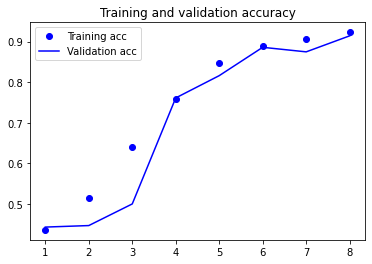

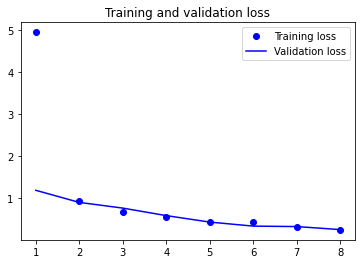

In [131]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training and Validation accuracy over epoch
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot Training and Validation loss over epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()